In [1]:
!pip install tensorflow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 762.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.NOWZWB_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [5]:
def preprocess(image,label):
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  image = tf.cast(image,tf.float32)/255.0
  return image,label

In [6]:
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)


In [8]:
x_train, y_train = dataset_to_numpy(ds_train)
x_test, y_test = dataset_to_numpy(ds_test)


In [9]:
#model 1 : CNN
models = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
models.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
history = models.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 467s 800ms/step - accuracy: 0.6145 - loss: 0.6416 - val_accuracy: 0.7644 - val_loss: 0.4979
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 463s 796ms/step - accuracy: 0.7723 - loss: 0.4755 - val_accuracy: 0.7977 - val_loss: 0.4378
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 461s 792ms/step - accuracy: 0.8196 - loss: 0.3915 - val_accuracy: 0.8285 - val_loss: 0.3837
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 461s 792ms/step - accuracy: 0.8651 - loss: 0.3169 - val_accuracy: 0.8126 - val_loss: 0.4024
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 464s 797ms/step - accuracy: 0.9013 - loss: 0.2393 - val_accuracy: 0.8442 - val_loss: 0.3806


In [20]:
y_pred = models.predict(x_test)
y_pred1 = (y_pred > 0.5).astype("int32").flatten()
acc = np.mean(y_pred1 == y_test)
print(f"accuracy by manual method: {acc * 100:.2f} %\n")
print(f"accuracy by tf : {models.evaluate(x_test,y_test)[1]*100} % \n")
print(f"loss by tf : {models.evaluate(x_test,y_test)[0]*100} % \n")
print(f"classification report : {classification_report(y_pred1,y_test,target_names=['Cat', 'Dog'])}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step
accuracy by manual method: 84.42 %

146/146 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 0.8406 - loss: 0.3942
accuracy by tf : 84.41530466079712 % 

146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 0.8406 - loss: 0.3942
loss by tf : 38.05854916572571 % 

classification report :               precision    recall  f1-score   support

         Cat       0.86      0.83      0.84      2377
         Dog       0.83      0.86      0.84      2275

    accuracy                           0.84      4652
   macro avg       0.84      0.84      0.84      4652
weighted avg       0.84      0.84      0.84      4652



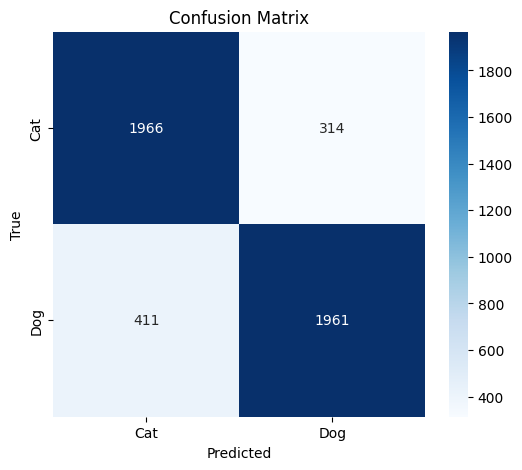

In [21]:
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

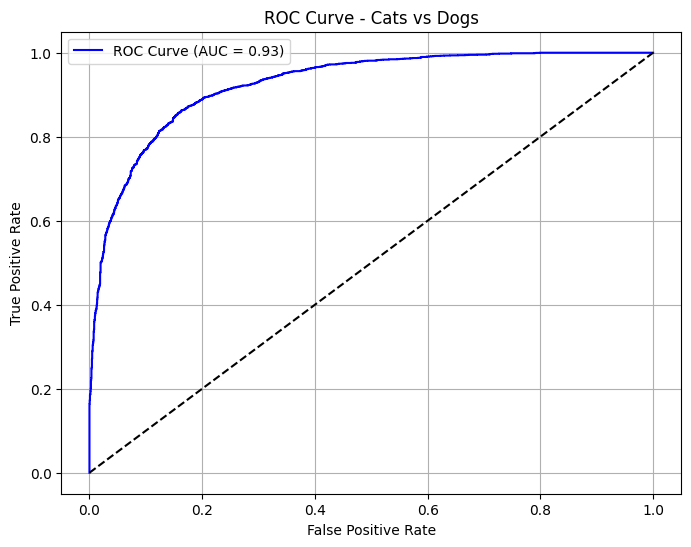

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Cats vs Dogs')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


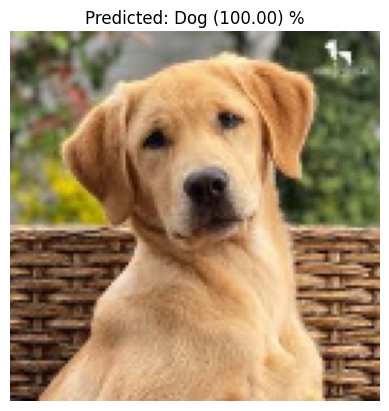

'Dog'

In [35]:
def predict_cat_dog(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found.")
        return -1

    img = cv2.resize(img, (128, 128))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_array = img_rgb / 255.0
    img_array = img_array.reshape(1, 128, 128, 3)
    pred = models.predict(img_array)[0][0]
    label = "Dog" if pred >= 0.5 else "Cat"
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label} ({pred*100:.2f}) %")
    plt.axis('off')
    plt.show()

    return label
predict_cat_dog("/content/download.jpg")